## Import libraries and such

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Load in an iris image and test Daugmans integro-differential operator

(240, 320, 3)
734.0078431372556


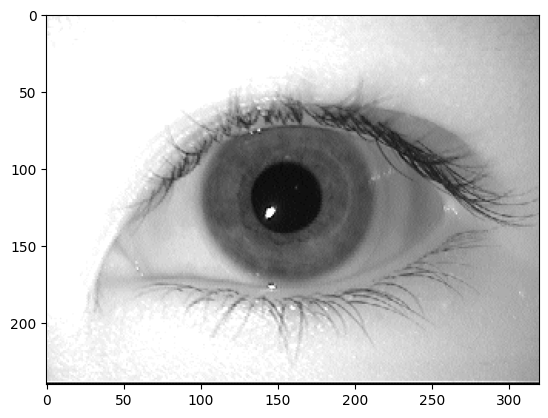

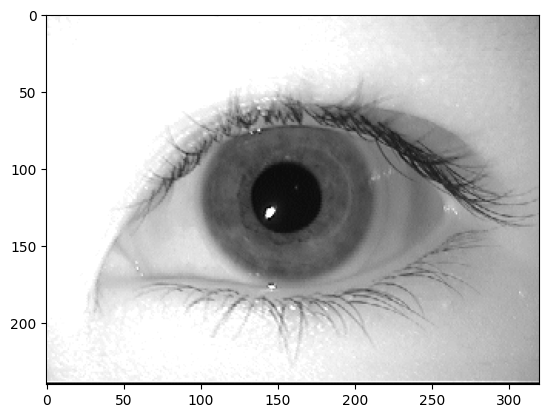

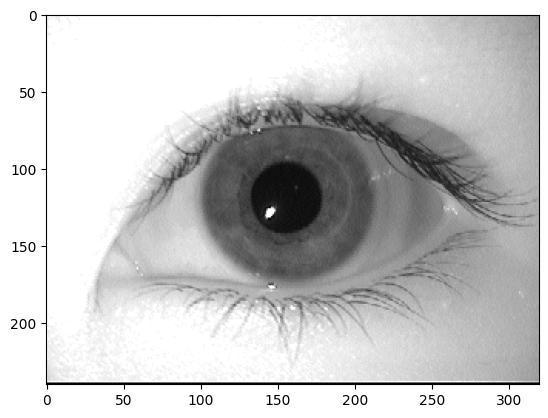

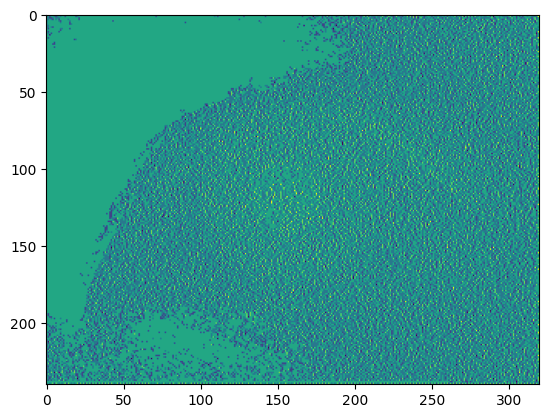

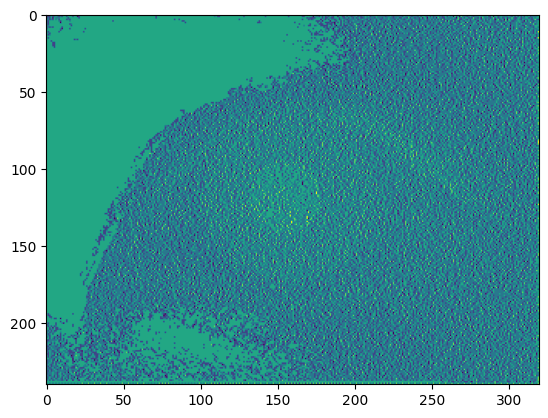

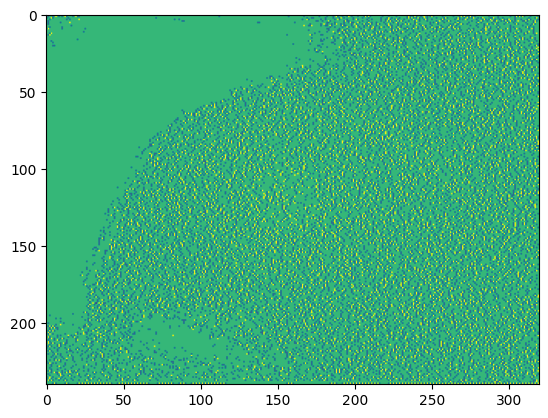

In [154]:
img = cv2.imread("MMU-Iris-Database/1/left/aeval1.bmp").astype(np.double) / 255
img2 = cv2.cvtColor(cv2.imread("MMU-Iris-Database/1/left/aeval1.bmp"), cv2.COLOR_BGR2GRAY)
print(img.shape)
print((np.abs(img[:, :, 2] - img[:, :, 1])).sum())
plt.imshow(img[:, :, 0], cmap="gray")
plt.show()
plt.imshow(img[:, :, 1], cmap="gray")
plt.show()
plt.imshow(img[:, :, 2], cmap="gray")
plt.show()
plt.imshow(img[:, :, 2] - img[:, :, 1])
plt.show()
plt.imshow(img[:, :, 0] - img[:, :, 1])
plt.show()
plt.imshow(img[:, :, 0] - img[:, :, 2])
plt.show()

### Daugmans integro-differential operator

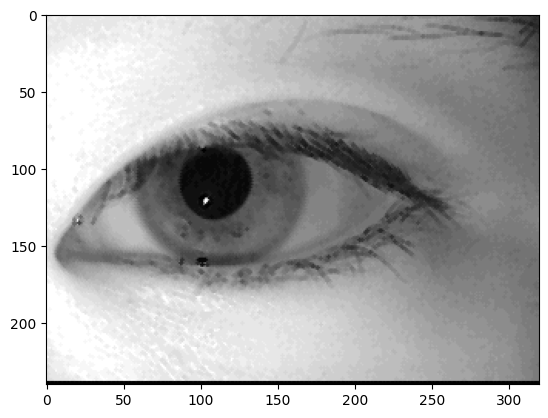

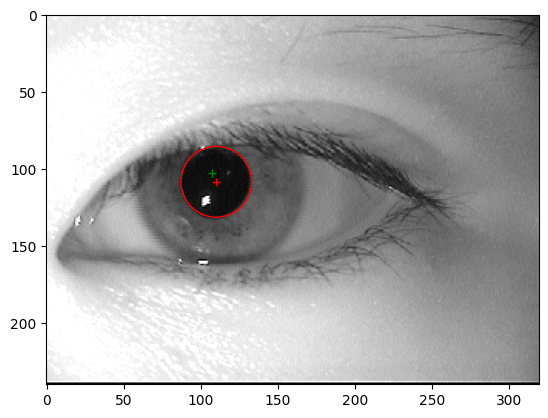

Optimal location and radius:  
x=110.0
y=108.0
r=23.0
Optimal location and radius:  
x=113.0
y=109.0
r=55.0


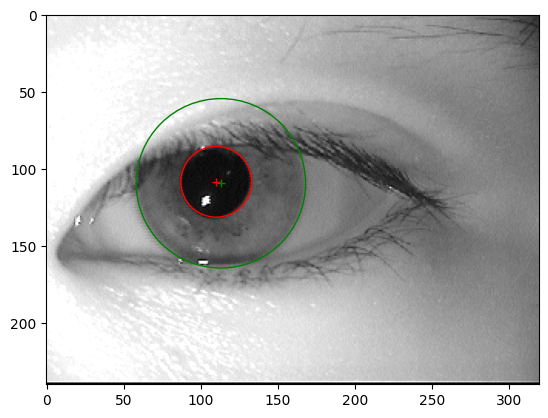

In [163]:
from scipy.signal import convolve2d
from matplotlib.patches import Circle
from typing import Optional

def circle_mask(r, xmax: int, ymax: int, x0r: int, y0r: int, lateral: bool=False) -> np.ndarray:
    circle = np.zeros((r + 1, r + 1)).astype(bool)
    circle_x, circle_y = np.meshgrid(np.arange(0, r + 1), np.arange(0, r + 1))
    circle_y = np.flip(circle_y, axis=0)
    dist = np.hstack([np.abs(circle_x ** 2 + circle_y ** 2 - r ** 2), np.ones(r + 1)[:, np.newaxis]*1e10])
    x0 = 0
    y0 = 0
    circle[y0, x0] = True
    incomplete_circle = True
    while incomplete_circle:

        if dist[y0, x0 + 1] < dist[y0 + 1, x0 + 1]:
            if dist[y0, x0 + 1] < dist[y0 + 1, x0]:
                x0 += 1
            else:
                y0 += 1
        elif dist[y0 + 1, x0 + 1] < dist[y0 + 1, x0]:
            y0 += 1
            x0 += 1
        else:
            y0 += 1
        circle[y0, x0] = True
        if y0 == r:
            incomplete_circle = False

    circle = np.hstack([np.flip(circle[:, 1:], axis=1), circle])
    circle = np.vstack([circle, np.flip(circle[:-1, :], axis=0)])
    if lateral:
        circle[:, r//2 + 1:-r//2] = False
    rxup = r
    ryup = r
    rxdown = r
    rydown = r
    if y0r < r:
        ryup = y0r
        circle = circle[(r - y0r):, :]
    if x0r < r:
        rxup = x0r
        circle = circle[:, (r - x0r):]
    if y0r + r + 1 > ymax:
        diff = y0r + r + 1 - ymax
        rydown = ymax - y0r - 1
        circle = circle[:-diff, :]
    if x0r + r + 1 > xmax:
        diff = x0r + r + 1 - xmax
        rxdown = xmax - x0r - 1
        circle = circle[:, :-diff]
    
    return circle, ryup, rydown, rxup, rxdown

def G(x: float, sigma: float=1.0) -> float:
    return np.exp(-x**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)

def LineIntegral(img: np.ndarray, r: int, x0: int, y0: int, lateral: bool=False) -> float:
    circle, ryup, rydown, rxup, rxdown = circle_mask(r, lateral=lateral, xmax=img.shape[1], ymax=img.shape[0], x0r=x0, y0r=y0)
    a = img[y0 - ryup:y0 + rydown + 1, x0 - rxup:x0 + rxdown + 1][circle]
    return (img[y0 - ryup:y0 + rydown + 1, x0 - rxup:x0 + rxdown + 1][circle]).sum() / circle.sum()

def drLineIntegral(img: np.ndarray, r: int, x0: int, y0: int, lateral: bool=False) -> float:
    return LineIntegral(img, r + 1, x0, y0, lateral=lateral) - LineIntegral(img, r, x0, y0, lateral=lateral)

def drLineIntegralMulti(img: np.ndarray, rmin: int, rmax: int, x0: int, y0: int, lateral: bool=False) -> np.ndarray:
    lint = np.zeros(rmax - rmin + 2)
    for r in range(rmin, rmax + 2):
        lint[r - rmin] = LineIntegral(img, r, x0, y0, lateral=lateral)
    return np.diff(lint)

def ConvolveGaussiandrLI(drLIM: np.ndarray, filter_size: int=3, sigma: float=1.0) -> np.ndarray:

    gf = np.exp(-(np.arange(filter_size) - filter_size // 2)**2/(2*sigma**2)) / (np.sqrt(2 * np.pi) * sigma)
    return np.convolve(drLIM, gf, mode="same")

def FindEdge(
        img: np.ndarray, 
        rmin: int, 
        rmax: int, 
        search_radius: int=5, 
        filter_size: int=3, 
        sigma: float=1.0, 
        lateral: bool=False, 
        plot_img: Optional[np.ndarray]=None, 
        plot_: bool=True,
        x0: Optional[int]=None,
        y0: Optional[int]=None
        ):
    
    # This seems like a good way to estimate a first guess of middle of eye,
    # but might be troublesome for darskinned people
    if x0 is None or y0 is None:
        img_x0y0 = (img < 0.07).astype(int)
        f = np.ones((20, 20))
        res = convolve2d(img_x0y0, f, mode="same")
        top_index = np.unravel_index(np.argmax(res), res.shape)
    else:
        top_index = (y0, x0)

    n = search_radius*2 + 1
    max_blur = np.zeros((n, n))
    opt_r = np.zeros((n, n))
    index_ = np.zeros((n, n, 2))
    r_vec = np.arange(rmin, rmax + 1)

    for i, y0 in enumerate(range(top_index[0] - search_radius, top_index[0] + search_radius + 1)):
        for j, x0 in enumerate(range(top_index[1] - search_radius, top_index[1] + search_radius + 1)):
            index_[i, j] = (y0, x0)
            drLIM = drLineIntegralMulti(img, rmin, rmax, x0, y0, lateral=lateral)
            cgdrLIM = ConvolveGaussiandrLI(drLIM, filter_size=filter_size, sigma=sigma)
            arg_max_blur = np.argmax(cgdrLIM)
            max_blur[i, j] = cgdrLIM[arg_max_blur]
            opt_r[i, j] = r_vec[arg_max_blur]
    
    max_blur_idx = np.unravel_index(np.argmax(max_blur), max_blur.shape)
    opt_xy = index_[max_blur_idx]
    opt_r = opt_r[max_blur_idx]
    if plot_:
        fig, ax = plt.subplots(1)
        if plot_img is not None:
            img = plot_img
        ax.imshow(img, cmap="gray")
        ax.plot(opt_xy[1], opt_xy[0], "r+")
        ax.plot(top_index[1], top_index[0], "g+")
        circle = Circle(opt_xy[::-1], opt_r, color="r", fill=False)
        ax.add_patch(circle)
        plt.show()
    print("Optimal location and radius: ", f"\nx={opt_xy[1]}\ny={opt_xy[0]}\nr={opt_r}")
    return opt_xy, opt_r

def FindPupilIris(img: np.ndarray, filter_size: int=3, sigma: float=1.0, lateral: bool=False, plot_img: Optional[np.ndarray]=None) -> int:

    struct_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    img_erode = cv2.erode(img, struct_elem, iterations=1)

    pup_xy, pup_r = FindEdge(img_erode, rmin=15, rmax=35, search_radius=10, filter_size=filter_size, sigma=sigma, lateral=True, plot_img=plot_img, plot_=False)
    iris_xy, iris_r = FindEdge(img, rmin=45, rmax=65, search_radius=4, filter_size=filter_size, sigma=sigma, lateral=lateral, plot_img=plot_img, plot_=False, x0=int(pup_xy[1]), y0=int(pup_xy[0]))

    fig, ax = plt.subplots(1)
    if plot_img is not None:
        img = plot_img
    ax.imshow(img, cmap="gray")
    ax.plot(pup_xy[1], pup_xy[0], "r+")
    ax.plot(iris_xy[1], iris_xy[0], "g+")
    circle_pup = Circle(pup_xy[::-1], pup_r, color="r", fill=False)
    circle_iris = Circle(iris_xy[::-1], iris_r, color="g", fill=False)
    ax.add_patch(circle_pup)
    ax.add_patch(circle_iris)
    plt.show()




img = cv2.imread("MMU-Iris-Database/36/left/tanwnl5.bmp").astype(np.double) / 255
img_use = img[:, :, 0]
struct_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
img_erode = cv2.erode(img_use, struct_elem, iterations=1)
plt.imshow(img_erode, cmap="gray")
plt.show()
#FindEdge(img_use, 40, 70, search_radius=12, filter_size=5, sigma=0.5, plot_img=img[:, :, 0], lateral=True)
FindPupilIris(img_use, filter_size=3, sigma=1, plot_img=img_use)